### Neural-Symbolic Integration for Explainable Revision

The following example will demonstrate how to use the LTN framwork for explainable classification tasks and subsequently adress some undesired model properties accordning to the following pipeline. 
In it we use Shapley methods as well as a Neural Network querying mechanism to gain insights into the modoel during our revision process.


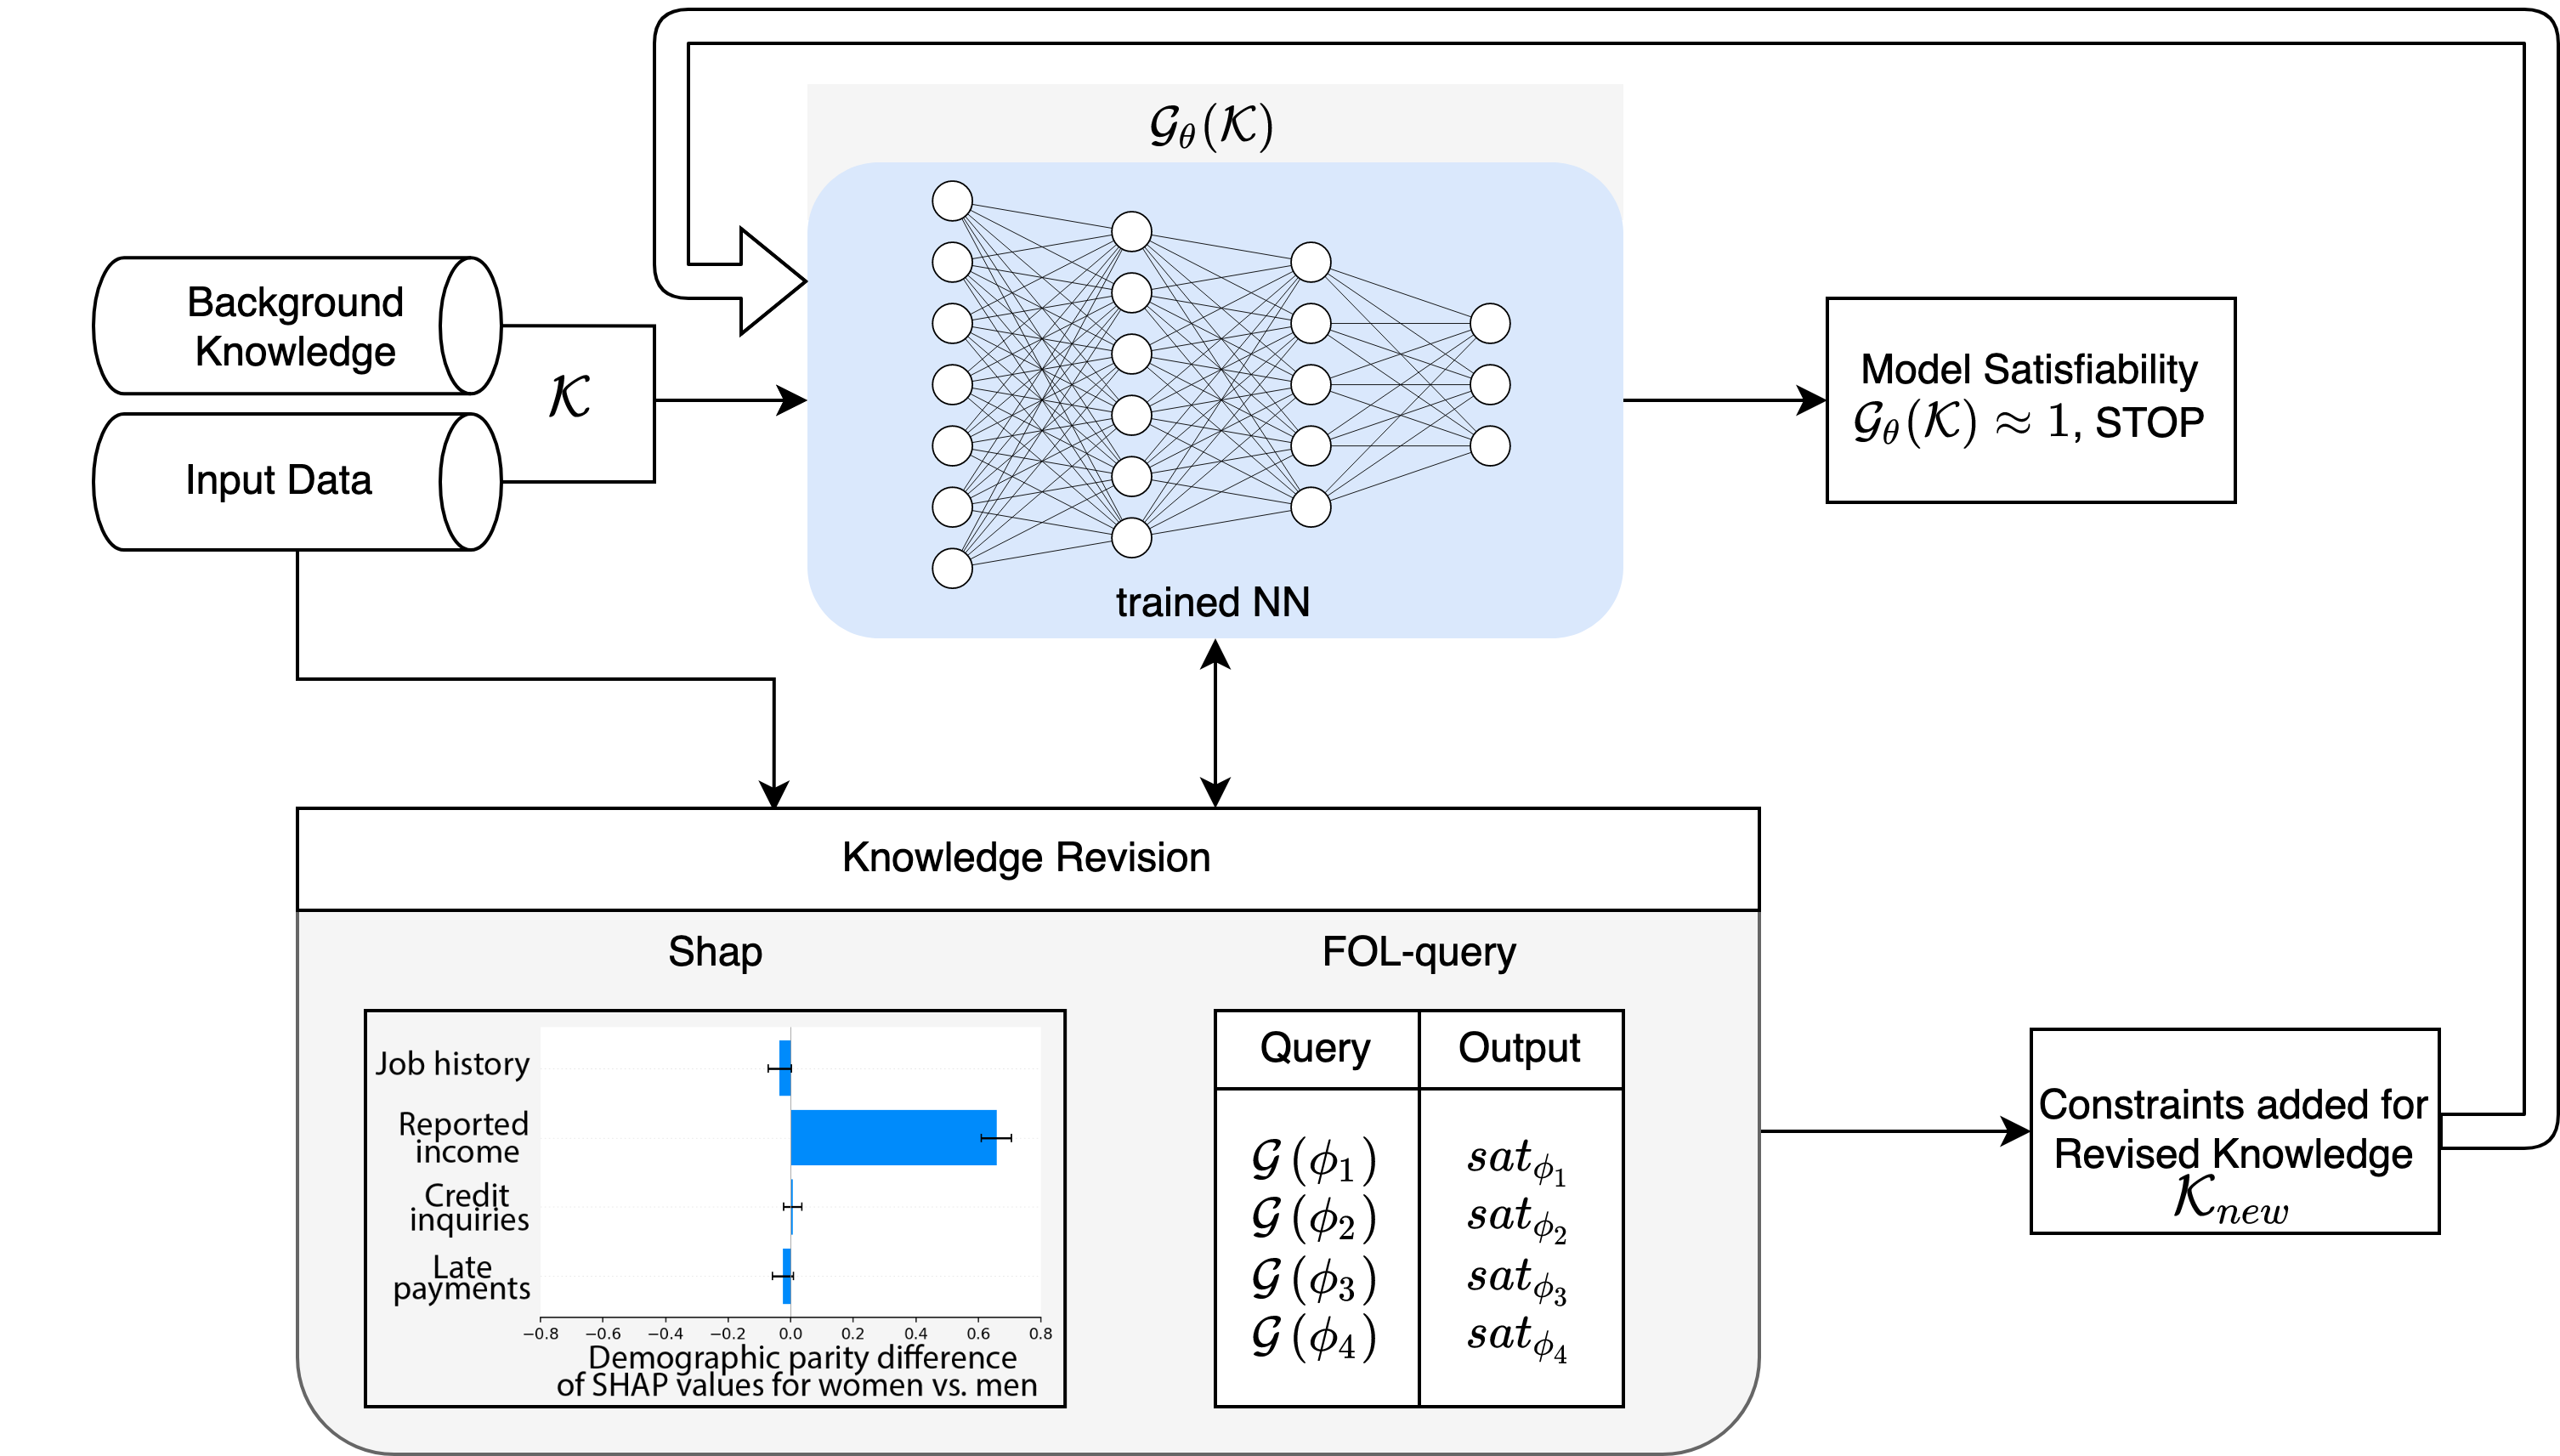

Revision is carried out by querying a deep network interactively and learning continually, thus applying the neural-symbolic cycle multiple times. Explanations extracted from the network using, e.g., SHAP can highlight bias or undesired properties in feature importance. Equally, querying the network in LTN-style shows the satisfiability of specific model properties, such as fairness constraints, which can subsequently be added to the knowledge base $\mathcal{K}$ for further training. Doing this, we can answer questions such as: *How does the model behave for a specific group of individuals compared to others?*, by translating into FOL queries %:  $\forall x \in \mathcal{R}_{P1}, y \in \mathcal{R}_{U1}: D(x) \leftrightarrow D(y)$ 
and checking their degree of satisfiability. 
In this specific example we only revise $\mathcal{K}$ once.


The tutorial introduces functions and objects from the Logictensornetwork framework. A four part tutorial can be found in the official repo: [LTN github](https://github.com/logictensornetworks/logictensornetworks). The relevant sessions are part 1-3.

We use the LTN framework for targeted aggregation that follows fuzzy logic to evaluate our queries that inform about potential disparities across different risk groups. We subsequently see if our revision can be further informed by calculating SHAP values. Lastly, we revise $\mathcal{K}$ by adding the FOL parity queries as soft constraint into the optimisation to simultaneously train the model to be accurate and fair. 

## Preparation

### Imports & Installations

In [ ]:
!pip install aif360
!pip install fairlearn
!git clone https://github.com/logictensornetworks/logictensornetworks.git repo_install
# !pip install "./repo_install/logictensornetworks/"
!mv "./repo_install/logictensornetworks" "./"

     |████████████████████████████████| 184kB 2.9MB/s 
     |████████████████████████████████| 358kB 17.9MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=fc9ac86c840b273e6da5baff262e4b6f544b137c0677f0df3078ce1c6fe70149
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=a575deea82cc0d09c4f3e5f1aea9f974c672bc651d9c300032b2d4f943e15275
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built memory-profiler shap
     |████████████████████████████████| 24.6MB 127kB/s 
Cloning into 'repo_install'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 339 (delta 47), reused 116 (delta 39), pack-reused 212
Receiving obj

In [ ]:
%matplotlib inline
import sys
import pandas as pd
import shap
import logictensornetworks as ltn
import logictensornetworks.fuzzy_ops as fuzzy_ops
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import ClassificationMetric

from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [ ]:
!wget -P /usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/ https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

--2021-05-21 13:40:44--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘/usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  9.56MB/s    in 0.3s    

2021-05-21 13:40:45 (9.56 MB/s) - ‘/usr/local/lib/python3.7/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv’ saved [2546489/2546489]



### Dataset preparation 

We use the compas dataset which has been discussed in the context of fairness. The model is used to predict recidivism to find possible reoffenders. The priviledged and unpriviledged groups are based on the attribute race. 

In [ ]:
## import dataset
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 2 # 1, 2

dataset_orig = CompasDataset()
if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
else:
    privileged_groups = [{'race': 1}]
    unprivileged_groups = [{'race': 0}]    

In [ ]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.8], shuffle=True)

## Model construction and Training

First we define the fuzzy logic definitions that will inform the model queries or any possible constraints.

The method is model agnostic and the LTN framework is used for the construction of the loss as well as interactive querying mechanism through fuzzy logic aggregation. 

In [ ]:
Not = ltn.Wrapper_Connective(fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(fuzzy_ops.Equiv(And,Implies))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=5), semantics="forall")

In [ ]:
def f(input):
  var_data = ltn.variable("input", input)
  result = D(var_data)
  return result.numpy()

class Predpred(object):
  # is a helper function to act as regular predicate predictor that outputs
  # true/false instead of fuzzy truth values. 
  def __init__(self, oracle):
        self.oracle = oracle
  def predict(self, data):
      var_data = ltn.variable("input", data)
      result = self.oracle(var_data)
      y_test_pred_prob = result.numpy()
      class_thresh = 0.5
      y_test_pred = np.zeros_like(y_test_pred_prob)
      y_test_pred[y_test_pred_prob >= class_thresh] = 1
      y_test_pred[~(y_test_pred_prob >= class_thresh)] = 0
      return y_test_pred

In [ ]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
positdata = X_train[y_train==1]
negatdata = X_train[y_train==0]
posits = np.asarray(positdata).astype(np.float32)
negats = np.asarray(negatdata).astype(np.float32)

We train using the inherent MLP function generator of the LTN library ```ltn.Predicate.MLP```. Any Keras Neural Network can be integrated here and passed into the ```ltn.Predicate``` wrapper (PyTorch adaptation will be released soon). For more details you can follow the tutorial in the original [repo](https://github.com/logictensornetworks/logictensornetworks).
The MLP function just needs the hidden layer sizes and input size (as list) and constructs the MLP accordingly with sigmoid as output neuron.

The following ``` axioms() ``` function specifies our knowledge-base $\mathcal{K}$. In this simple example,  $\mathcal{K}$ just immitates regular supervised learning. It returns the sat_level of the entire $\mathcal{K}$ as well as individual axioms within. 



In [ ]:
var_posit = ltn.variable("posits",posits)
var_negat = ltn.variable("negats",negats)
D = ltn.Predicate.MLP([401],hidden_layer_sizes=(100,50))
trainable_variables = D.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=5)

@tf.function
def axioms():
    axioms = []
    weights = []
    # forall data_A: D(data_A)
    axioms.append(Forall(var_posit, D(var_posit)))
    # forall data_B: D(data_B)
    axioms.append(Forall(var_negat, Not(D(var_negat))))
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

axioms()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.39950365>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.39464784, 0.40460426], dtype=float32)>)

The following is the optimisation of sat-level of $\mathcal{K}$ by optimising the MLP. As mentioned previously, here we only do regular binary classification and also report the accuracy (although optimisation is based on sat-level). The gradienttape is basic Keras optimisation - a PyTorch version of the LTN library will be published and linked when ready.  

We refer to the intermediate outputs of the model as oracle as the model itself can consist of more than a single MLP (demonstrated in the accompanying tutorials) and returns fuzzy truth values. An oracle here refers exclusively to a Predicate prediction which is already translated into binary outputs. 

In [ ]:
for epoch in range(6000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()[0]
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        oracle = Predpred(D)
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()[0]),
                  "Epoch %d: Train-Accuracy %.3f"%(epoch, 
                                                   accuracy_score(y_train,
                                                                  oracle.predict(X_train))))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()[0]))

Epoch 0: Sat Level 0.460 Epoch 0: Train-Accuracy 0.539
Epoch 200: Sat Level 0.560 Epoch 200: Train-Accuracy 0.819
Epoch 400: Sat Level 0.576 Epoch 400: Train-Accuracy 0.854
Epoch 600: Sat Level 0.588 Epoch 600: Train-Accuracy 0.859
Epoch 800: Sat Level 0.596 Epoch 800: Train-Accuracy 0.885
Epoch 1000: Sat Level 0.596 Epoch 1000: Train-Accuracy 0.891
Epoch 1200: Sat Level 0.610 Epoch 1200: Train-Accuracy 0.906
Epoch 1400: Sat Level 0.607 Epoch 1400: Train-Accuracy 0.908
Epoch 1600: Sat Level 0.612 Epoch 1600: Train-Accuracy 0.903
Epoch 1800: Sat Level 0.619 Epoch 1800: Train-Accuracy 0.916
Epoch 2000: Sat Level 0.623 Epoch 2000: Train-Accuracy 0.919
Epoch 2200: Sat Level 0.625 Epoch 2200: Train-Accuracy 0.924
Epoch 2400: Sat Level 0.625 Epoch 2400: Train-Accuracy 0.925
Epoch 2600: Sat Level 0.621 Epoch 2600: Train-Accuracy 0.929
Epoch 2800: Sat Level 0.621 Epoch 2800: Train-Accuracy 0.926
Epoch 3000: Sat Level 0.623 Epoch 3000: Train-Accuracy 0.929
Epoch 3200: Sat Level 0.623 Epoch 3200

## Knowledge Revision



### FOL Queries

Now we use the model logits as well as the protected attributes to create variables that will inform our queries. In this example our focus is only querying the output with respect to a specific protected variable as we are interested in fairness. However, any combination of features or even intermediate representation as well as combination of models can be queried using fuzzy logic. Here we use the common notion of *Demographic parity difference* as fairness criterion. We want the model to behave similarly for individuals of both races (protected attribute) in predicting recidivism. 

A classifier $h$ satisfies demographic parity under a distribution on $(X, A, Y)$ if its predictions $h(X)$ are independent of the protected attribute $A$. 
\noindent That is, $\forall a \in {A}$:
$$
\mathbf{P}[h(X)=Y \mid A=a]=\mathbf{P}[h(X)=Y]
$$
Since $Y \in\{0,1\}$, we can say that: 
$$
\forall a: \mathbb{E}[h(X) \mid A=a]=\mathbb{E}[h(X)]
$$


We create discretisations based on biased logits to create parity classes (groups) based on their relative risk factors. We only discretise into 5 groups to gain insights how treatment of protected and unprotected group differs. This can be made with any arbitrary number of groups as well as combination of groups. The FOL fuzzy aggregation will automatically query and aggregate according to the desired query. A further query could be focused on how treatment differes along groups of specific age in risk and protected attribute

In this example we split the data externally to make the process transparent for the reader. However, the latest iteration of LTN allows for dynamic masking internally during aggregation which means the splitting can be done within the language using custom masks (see LTN tutorials for detailed demonstration). 

In [ ]:
%%capture
# capture is an IPy function to surpress some of the display information
X_df = pd.DataFrame(X_train,columns=dataset_orig.feature_names)
X_r_preds = f(np.asarray(X_train).astype(np.float32))
X_df['logits'] = X_r_preds
X_prot1 = X_df[X_df['race'] == X_df['race'].unique()[0]] # unprivileged (group 1)
X_prot2 = X_df[X_df['race'] == X_df['race'].unique()[1]] # privileged (group 2)
X_prot1['logit_class'] = pd.qcut(X_prot1['logits'],5, labels=[0,1,2,3,4])
X_prot2['logit_class'] = pd.qcut(X_prot2['logits'],5, labels=[0,1,2,3,4])
X_inp = pd.concat([X_prot2,X_prot1])

# The first loop above creates the parity classes based on the protected attribute race.
# We iterate 5-times for every group and create a DataFrame for better data handling.
# Subsequently we generate a variable that allows us to query anything for better model understanding 

a = {}
for i in range(5):
  groupP = f"class{i}P"
  groupN = f"class{i}N"
  v_prot = X_inp[X_inp['race'] == X_inp['race'].unique()[0]][X_inp['logit_class'] == i]
  v_unprot = X_inp[X_inp['race'] == X_inp['race'].unique()[1]][X_inp['logit_class'] == i]
  a[groupP] = v_prot
  a[groupN] = v_unprot

for item in a:
  print(item + "  LTN variable assigned")
  globals()[f"var_{item}"] = ltn.variable(f"?{item}",a[item].iloc[:,:-2].astype(np.float32).to_numpy())

Once we have obtained different risk groups, we can use the LTN module to evaluate the FOL-queries according to the specified fuzzy logic. With it we can answer questions like:
*How does the model behave for a specific group? How does the model behave for particular edge cases?*

The following queries are concerned with how the model behaves differently for priviledged and unpriviledge group across different recidivism risks as we are interested in parity fairness as defined above. 

In [ ]:
display(Markdown("#### Model - with bias - parity difference using FOL queries"))
print(" Parity in group 1 = %f" % Forall((var_class0P,var_class0N), Equiv(D(var_class0P),D(var_class0N)),p=2).numpy())
print(" Parity in group 2 = %f" % Forall((var_class1P,var_class1N), Equiv(D(var_class1P),D(var_class1N)),p=2).numpy())
print(" Parity in group 3 = %f" % Forall((var_class2P,var_class2N), Equiv(D(var_class2P),D(var_class2N)),p=2).numpy())
print(" Parity in group 4 = %f" % Forall((var_class3P,var_class3N), Equiv(D(var_class3P),D(var_class3N)),p=2).numpy())
print(" Parity in group 5 = %f" % Forall((var_class4P,var_class4N), Equiv(D(var_class4P),D(var_class4N)),p=2).numpy())

#### Model - with bias - parity difference using FOL queries

 Parity in group 1 = 0.987337
 Parity in group 2 = 0.774051
 Parity in group 3 = 0.544712
 Parity in group 4 = 0.675256
 Parity in group 5 = 0.989366


The parities above clearly show that the model is picking up on biases with respect to groups of medium risk of revicidism. While on the extremes, meaning in groups where the risk is very low or very high, there are no significant differences in treatment for protected and unprotected group.




### Shapley values

We complement our observation made by the FOL-queries using the Shapley method. Here we can use the SHAP value to dissect unfair treatment of different ethnic groups based on specific feature values. 

Shap is used by sampling from the dataset as referencing. One consequence is that the Demographic parity is calculated across all risk groups.
For a detailed explanation of the demographic parity calculations, we refer the reader to the [original tutorial](https://notebook.community/slundberg/shap/notebooks/general/Explaining%20Quantitative%20Measures%20of%20Fairness) by Scott Lundberg.

Negative values mean black people have a higher average predicted risk than white, and vice versa. Fair models (based on the common notion introduced above) converge toward zero.

In [ ]:
explainer = shap.KernelExplainer(f, shap.sample(X_train, 100)) # KernelExplainer is used for it's flexibility to all types of models
shap_values = explainer.shap_values(X_train[:50])

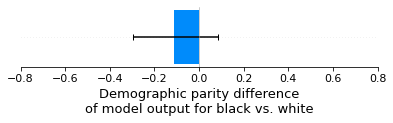

In [ ]:
glabel = "Demographic parity difference\nof model output for black vs. white"
xmin = -0.8
xmax = 0.8
race_mask = np.array(dataset_orig.features[:,2], dtype=bool) 
shap.group_difference_plot(shap_values.sum(1), race_mask[:50], xmin=xmin, xmax=xmax, xlabel=glabel)

We can further use Shap to dissect where the disparities are manifested in the data. We can see that depending on the ethnic group, age can play a different role for both groups. 
This can be interpreted as age playing a disporportinately big impact for poeple of the protected ethnic group. However, not a single feature is the cause of any disparity but rather a combination of many different features, which makes it difficult to address. 

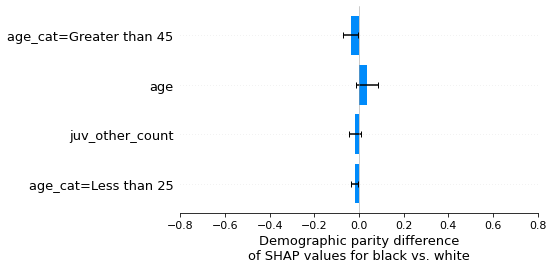

In [ ]:
slabel = "Demographic parity difference\nof SHAP values for black vs. white race."
shap.group_difference_plot(shap_values, race_mask[:50], dataset_orig.feature_names, xmin=xmin, xmax=xmax, xlabel=slabel,max_display=4)


## Adressing undesired properties by using the FOL queries as constraints

We train the model further as visualised in the figure above in an active learning approach by adding the output of the queries as additional constraint in order to adress the unfair treatment of protected groups. We do this by specifying $\mathcal{K}_{new}$ based on the revision above. The gradient update here will simultaneously optimise for an accurate and fair model. 
As mentioned before, the method is agnostic as LTN is used for constructing the loss. 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=4)

@tf.function
def axioms():
    axioms = []
    weights = []
    # forall data_A: D(data_A)
    axioms.append(Forall(var_posit, D(var_posit)))
    weights.append(2.)
    # forall data_B: D(data_B)
    axioms.append(Forall(var_negat, Not(D(var_negat))))
    weights.append(2.)
    # Equality Constraints
    # Note that the weights above are higher - meaning the relative importance of the classification axioms 
    # is higher than the fairness axioms. This can be tweaked to the users desire (accuracy-parity tradeoff). 
    axioms.append(Forall((var_class0P,var_class0N), Equiv(D(var_class0P),D(var_class0N)),p=2))
    weights.append(1)
    axioms.append(Forall((var_class1P,var_class1N), Equiv(D(var_class1P),D(var_class1N)),p=2))
    weights.append(1)
    axioms.append(Forall((var_class2P,var_class2N), Equiv(D(var_class2P),D(var_class2N)),p=2))
    weights.append(1)
    axioms.append(Forall((var_class3P,var_class3N), Equiv(D(var_class3P),D(var_class3N)),p=2))
    weights.append(1)
    axioms.append(Forall((var_class4P,var_class4N), Equiv(D(var_class4P),D(var_class4N)),p=2))
    weights.append(1)
    axioms = tf.stack([tf.squeeze(ax) for ax in axioms])
    weights = tf.stack(weights)
    weighted_axioms = weights*axioms
    sat_level = formula_aggregator(weighted_axioms)
    return sat_level, axioms

axioms()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.60902584>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.4787253, 0.5063261, 0.9996098, 0.9437169, 0.6040298, 0.7256386,
        0.9988771], dtype=float32)>)

In [ ]:
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()[0]
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        oracle = Predpred(D)
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()[0]),
                  "Epoch %d: Train-Accuracy %.3f"%(epoch, 
                                                   accuracy_score(y_train,
                                                                  oracle.predict(X_train))))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()[0]))

Epoch 0: Sat Level 0.380 Epoch 0: Train-Accuracy 0.725
Epoch 200: Sat Level 0.612 Epoch 200: Train-Accuracy 0.891
Epoch 400: Sat Level 0.612 Epoch 400: Train-Accuracy 0.894
Epoch 600: Sat Level 0.612 Epoch 600: Train-Accuracy 0.890
Epoch 800: Sat Level 0.613 Epoch 800: Train-Accuracy 0.895
Epoch 1000: Sat Level 0.613 Epoch 1000: Train-Accuracy 0.899
Epoch 1200: Sat Level 0.614 Epoch 1200: Train-Accuracy 0.896
Epoch 1400: Sat Level 0.612 Epoch 1400: Train-Accuracy 0.899
Epoch 1600: Sat Level 0.613 Epoch 1600: Train-Accuracy 0.889
Epoch 1800: Sat Level 0.577 Epoch 1800: Train-Accuracy 0.882
Epoch 2000: Sat Level 0.612 Epoch 2000: Train-Accuracy 0.898
Epoch 2200: Sat Level 0.612 Epoch 2200: Train-Accuracy 0.902
Epoch 2400: Sat Level 0.612 Epoch 2400: Train-Accuracy 0.900
Epoch 2600: Sat Level 0.613 Epoch 2600: Train-Accuracy 0.893
Epoch 2800: Sat Level 0.614 Epoch 2800: Train-Accuracy 0.897
Training finished at Epoch 2999 with Sat Level 0.615


In [ ]:
for epoch in range(3000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()[0]
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        oracle = Predpred(D)
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()[0]),
                  "Epoch %d: Train-Accuracy %.3f"%(epoch, 
                                                   accuracy_score(y_train,
                                                                  oracle.predict(X_train))))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()[0]))

Epoch 0: Sat Level 0.474 Epoch 0: Train-Accuracy 0.723
Epoch 200: Sat Level 0.603 Epoch 200: Train-Accuracy 0.895
Epoch 400: Sat Level 0.608 Epoch 400: Train-Accuracy 0.882
Epoch 600: Sat Level 0.609 Epoch 600: Train-Accuracy 0.893
Epoch 800: Sat Level 0.610 Epoch 800: Train-Accuracy 0.894
Epoch 1000: Sat Level 0.608 Epoch 1000: Train-Accuracy 0.901
Epoch 1200: Sat Level 0.610 Epoch 1200: Train-Accuracy 0.894
Epoch 1400: Sat Level 0.609 Epoch 1400: Train-Accuracy 0.901
Epoch 1600: Sat Level 0.611 Epoch 1600: Train-Accuracy 0.888
Epoch 1800: Sat Level 0.610 Epoch 1800: Train-Accuracy 0.891
Epoch 2000: Sat Level 0.611 Epoch 2000: Train-Accuracy 0.885
Epoch 2200: Sat Level 0.610 Epoch 2200: Train-Accuracy 0.902
Epoch 2400: Sat Level 0.611 Epoch 2400: Train-Accuracy 0.895
Epoch 2600: Sat Level 0.610 Epoch 2600: Train-Accuracy 0.885
Epoch 2800: Sat Level 0.610 Epoch 2800: Train-Accuracy 0.898
Training finished at Epoch 2999 with Sat Level 0.611


In [ ]:
explainer = shap.KernelExplainer(f, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_train[:50])

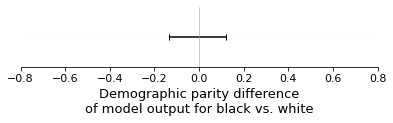

In [ ]:
glabel = "Demographic parity difference\nof model output for black vs. white"
xmin = -0.8
xmax = 0.8
race_mask = np.array(dataset_orig.features[:,2], dtype=bool) 
shap.group_difference_plot(shap_values.sum(1), race_mask[:50], xmin=xmin, xmax=xmax, xlabel=glabel)

Here we can see that the undesired pairty difference has been decreased to 0 which means that black and white prisoners are treated similarly with respect to their individual risk (following the parity definition above). The dissection of disparity into different features has shifted but again hints at any remaining disparity being distributed across many features.

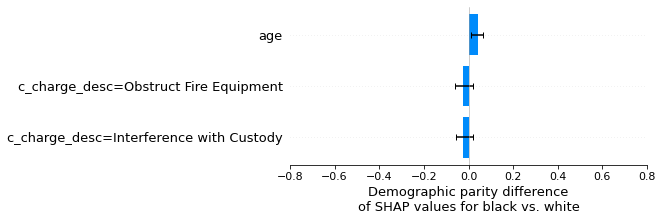

In [ ]:
slabel = "Demographic parity difference\nof SHAP values for black vs. white"
shap.group_difference_plot(shap_values, race_mask[:50], dataset_orig.feature_names, xmin=xmin, xmax=xmax, xlabel=slabel,max_display=3)


In [ ]:
%%capture
X_df = pd.DataFrame(X_train,columns=dataset_orig.feature_names)
X_r_preds = f(np.asarray(X_train).astype(np.float32))
X_df['logits'] = X_r_preds
X_prot1 = X_df[X_df['race'] == X_df['race'].unique()[0]]
X_prot2 = X_df[X_df['race'] == X_df['race'].unique()[1]]
X_prot1['logit_class'] = pd.qcut(X_prot1['logits'],5, labels=[0,1,2,3,4])
X_prot2['logit_class'] = pd.qcut(X_prot2['logits'],5, labels=[0,1,2,3,4])
X_inp = pd.concat([X_prot2,X_prot1])

a = {}
for i in range(5):
  groupP = f"class{i}P"
  groupN = f"class{i}N"
  v_prot = X_inp[X_inp['race'] == X_inp['race'].unique()[0]][X_inp['logit_class'] == i]
  v_unprot = X_inp[X_inp['race'] == X_inp['race'].unique()[1]][X_inp['logit_class'] == i]
  a[groupP] = v_prot
  a[groupN] = v_unprot

for item in a:
  print(item + "  LTN variable assigned")
  globals()[f"var_{item}"] = ltn.variable(f"?{item}",a[item].iloc[:,:-2].astype(np.float32).to_numpy())

In [ ]:
display(Markdown("#### Model - without bias - parity difference using FOL queries"))
print(" Parity in group 1 = %f" % Forall((var_class0P,var_class0N), Equiv(D(var_class0P),D(var_class0N)),p=2).numpy())
print(" Parity in group 2 = %f" % Forall((var_class1P,var_class1N), Equiv(D(var_class1P),D(var_class1N)),p=2).numpy())
print(" Parity in group 3 = %f" % Forall((var_class2P,var_class2N), Equiv(D(var_class2P),D(var_class2N)),p=2).numpy())
print(" Parity in group 4 = %f" % Forall((var_class3P,var_class3N), Equiv(D(var_class3P),D(var_class3N)),p=2).numpy())
print(" Parity in group 5 = %f" % Forall((var_class4P,var_class4N), Equiv(D(var_class4P),D(var_class4N)),p=2).numpy())

#### Model - without bias - parity difference using FOL queries

 Parity in group 1 = 0.999620
 Parity in group 2 = 0.943389
 Parity in group 3 = 0.608645
 Parity in group 4 = 0.767822
 Parity in group 5 = 0.999509


We have given more relative importance to the classification task with respect to equal treatment but this trade-off can be tuned to the users desire as shown in the first cell of this section. 

We can see that the unfair treatment of different risk groups has decreased significantly while retaining high accuracy. [In the paper](https://openaccess.city.ac.uk/id/eprint/26151/), we measure the effect on accuracy and benchmark model perfomance and fairness against other fairness-focused methods. 

